In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle


import mido
from mido import MidiFile
from copy import deepcopy

from sklearn import metrics
from sklearn.metrics import _classification

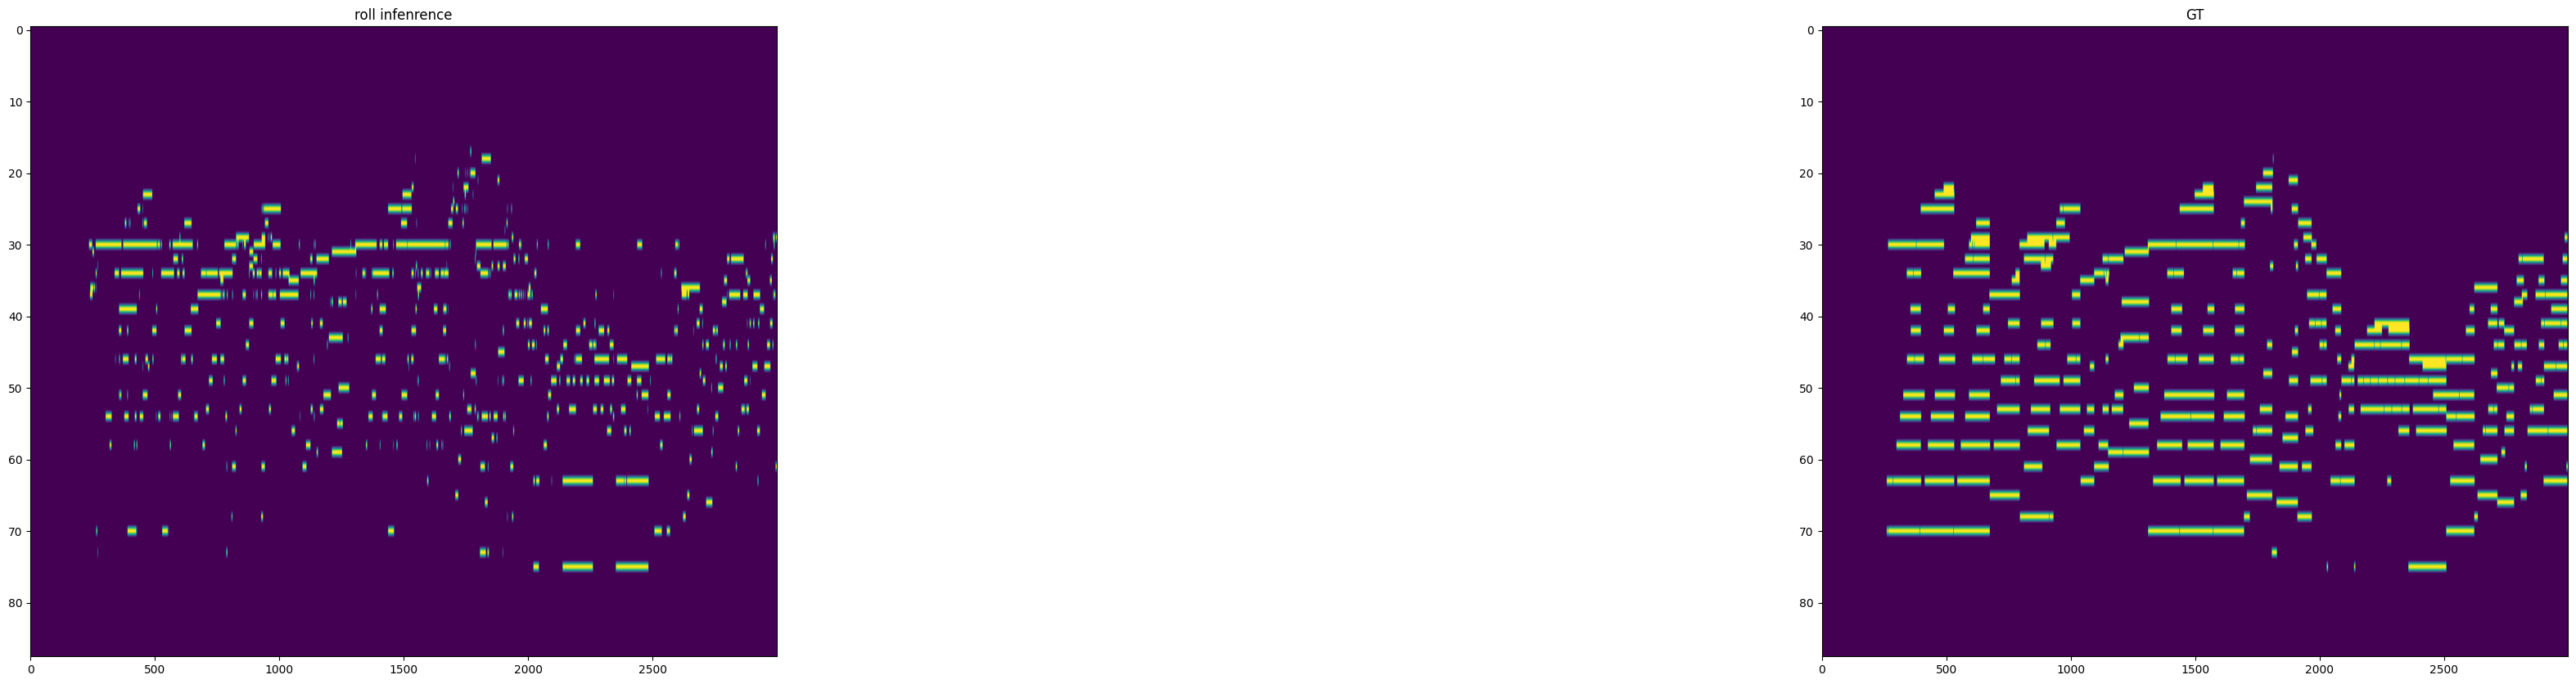

In [9]:
song_name = "116_“Méditation de Thaïs” Massenet PIANO SOLO + FREE SHEET MUSIC.mp4"
indices = slice(0, 3000)

plot_roll = True
plot_midi = False
plot_gt   = True

if plot_roll:
    test_roll_gen_path = os.path.join("./outputs_test/v2r_output", song_name)
    test_midi_gen_list = sorted(os.listdir(test_roll_gen_path), key=lambda x: int(x.split('-')[0]))
    test_midi_gen_list = [os.path.join(test_roll_gen_path, midi_gen) for midi_gen in test_midi_gen_list]
    midi_roll_cat = []
    for midi_gen in test_midi_gen_list:
        midi_roll_cat.append(np.load(midi_gen)['roll'])

if plot_midi:
    test_midi_gen_path = os.path.join("./outputs_test/r2m_output", song_name)
    test_midi_gen_list = sorted(os.listdir(test_midi_gen_path), key=lambda x: int(x.split('-')[0]))
    test_midi_gen_list = [os.path.join(test_midi_gen_path, midi_gen) for midi_gen in test_midi_gen_list]
    midi_gen_cat = []
    for midi_gen in test_midi_gen_list:
        midi_gen_cat.append(np.load(midi_gen)['midi'])

if plot_gt:
    gt = np.load(os.path.join("./data/ytdataset/labels_audeo/testing", song_name+".pkl"), allow_pickle=True)
    # gt = np.load(os.path.join("./data/MIDItest/labels/testing", song_name+".pkl"), allow_pickle=True)
    # gt = np.load(os.path.join("./data/bommelpiano_pad/labels/testing", song_name+".pkl"), allow_pickle=True)

    gt_np = []
    for k, v in gt.items():
        gt_np.append(v)

plt.figure(figsize=(40, 10))
if plot_roll:
    plt.subplot(1, 3, 1)
    plt.title("roll infenrence")
    plt.imshow(np.concatenate(midi_roll_cat, axis=0)[indices, ::-1].transpose(), aspect="auto")
    # plt.imshow(torch.sigmoid(torch.tensor(np.concatenate(midi_roll_cat, axis=0)[indices, ::-1].transpose().copy()))>0.05)
if plot_midi:
    plt.subplot(1, 3, 2)
    plt.title("midi inference")
    plt.imshow(np.pad(
        np.concatenate(midi_gen_cat, axis=0)[indices, ::-1].transpose(),
        ((0, 3), (0, 0)), 'constant', constant_values=0), aspect="auto")
if plot_gt:
    plt.subplot(1, 3, 3)
    plt.title("GT")
    plt.imshow(np.stack(gt_np)[indices, ::-1].transpose() > 0, aspect="auto")

In [2]:
def _prf_divide(numerator, denominator, zero_division="warn"):
    """Performs division and handles divide-by-zero.
    On zero-division, sets the corresponding result elements equal to
    0 or 1 (according to ``zero_division``). Plus, if
    ``zero_division != "warn"`` raises a warning.
    The metric, modifier and average arguments are used only for determining
    an appropriate warning.
    """
    mask = denominator == 0.0
    denominator = denominator.copy()
    denominator[mask] = 1  # avoid infs/nans
    result = numerator / denominator

    if not np.any(mask):
        return result

    # if ``zero_division=1``, set those with denominator == 0 equal to 1
    result[mask] = 0.0 if zero_division in ["warn", 0] else 1.0

    # the user will be removing warnings if zero_division is set to something
    # different than its default value. If we are computing only f-score
    # the warning will be raised only if precision and recall are ill-defined
    if zero_division != "warn":
        return result

In [11]:
from sklearn import metrics
from sklearn.metrics import _classification

# all_pred_label = np.pad(np.concatenate(midi_cat, axis=0), ((0, 0), (0, 3)), 'constant', constant_values=0)
all_pred_label = np.concatenate(midi_roll_cat, axis=0)
all_label = np.stack(gt_np)[:all_pred_label.shape[0]] > 1

labels = _classification._check_set_wise_labels(all_label, all_pred_label, labels=None, pos_label=1, average='samples')
MCM = metrics.multilabel_confusion_matrix(all_label, all_pred_label,sample_weight=None, labels=labels, samplewise=True)
tp_sum = MCM[:, 1, 1]
fp_sum = MCM[:, 0, 1]
fn_sum = MCM[:, 1, 0]
# tn_sum = MCM[:, 0, 0]
accuracy = _prf_divide(tp_sum, tp_sum+fp_sum+fn_sum, zero_division=1)
accuracy = np.average(accuracy)
all_precision = metrics.precision_score(all_label, all_pred_label, average=None, zero_division=np.nan)
all_recall = metrics.recall_score(all_label, all_pred_label, average=None, zero_division=np.nan)
all_f1_score = metrics.f1_score(all_label, all_pred_label, average=None, zero_division=np.nan)

all_precision_original = metrics.precision_score(all_label, all_pred_label, average="samples", zero_division=1)
all_recall_original = metrics.recall_score(all_label, all_pred_label, average="samples", zero_division=1)
all_f1_score_original = metrics.f1_score(all_label, all_pred_label, average="samples", zero_division=1)

In [12]:
print(np.nansum(all_precision) / np.count_nonzero(~np.isnan(all_precision)),
      np.nansum(all_recall) / np.count_nonzero(~np.isnan(all_recall)),
      np.nansum(all_f1_score) / np.count_nonzero(~np.isnan(all_f1_score)))

0.6627003964491157 0.3427260000859409 0.4056783412053171


In [13]:
print(accuracy, all_precision_original, all_recall_original, all_f1_score_original)

0.37367455052883625 0.723364081632653 0.42659376877091165 0.5658645727970982


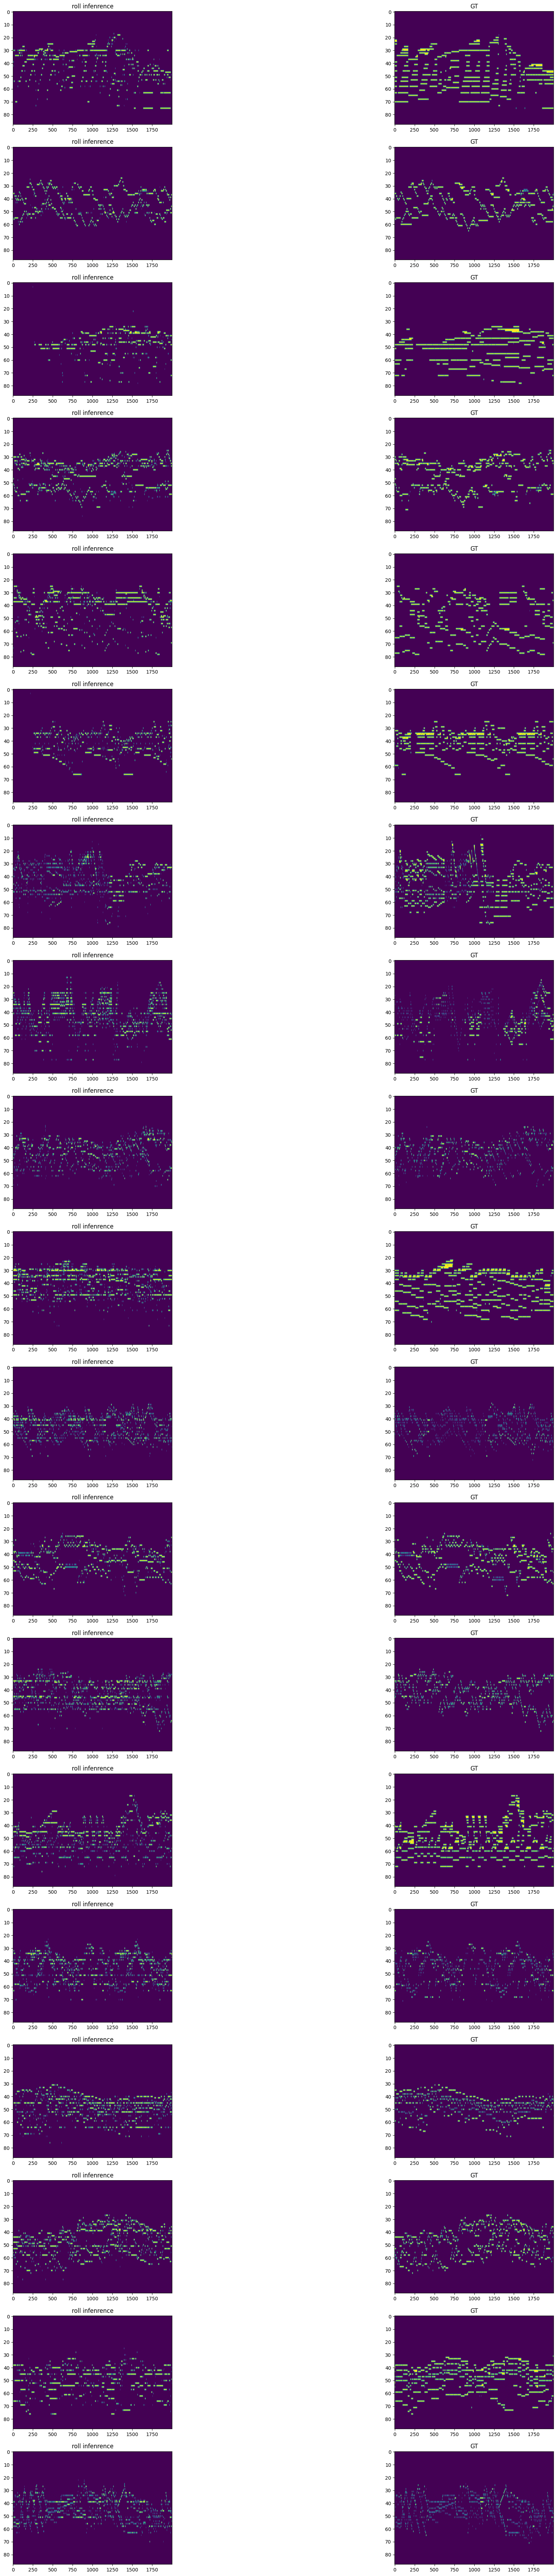

In [44]:
multi_infer_path_base = "./outputs_exp35/outputs_test"
multi_infer_path_roll = os.path.join(multi_infer_path_base, "v2r_output")
data_len = len(os.listdir(multi_infer_path_roll))
metrics_all = {}
plt.figure(figsize=(20, 5*data_len))
for i, names in enumerate(os.listdir(multi_infer_path_roll)):
    #if names == ".ipynb_ckechpoint
    song_name = names
    indices = slice(500, 2500)

    plot_roll = True
    plot_midi = False
    plot_gt   = True

    if plot_roll:
        test_roll_gen_path = os.path.join(multi_infer_path_roll, song_name)
        test_midi_gen_list = sorted(os.listdir(test_roll_gen_path), key=lambda x: int(x.split('-')[0]))
        test_midi_gen_list = [os.path.join(test_roll_gen_path, midi_gen) for midi_gen in test_midi_gen_list]
        midi_roll_cat = []
        for midi_gen in test_midi_gen_list:
            midi_roll_cat.append(np.load(midi_gen)['roll'])

    if plot_midi:
        test_midi_gen_path = os.path.join(multi_infer_path_base, "r2m_output", song_name)
        test_midi_gen_list = sorted(os.listdir(test_midi_gen_path), key=lambda x: int(x.split('-')[0]))
        test_midi_gen_list = [os.path.join(test_midi_gen_path, midi_gen) for midi_gen in test_midi_gen_list]
        midi_gen_cat = []
        for midi_gen in test_midi_gen_list:
            midi_gen_cat.append(np.load(midi_gen)['midi'])

    if plot_gt:
        gt = np.load(os.path.join("./data/ytdataset/labels_audeo/testing", song_name+".pkl"), allow_pickle=True)
        # gt = np.load(os.path.join("./data/MIDItest/labels/testing", song_name+".pkl"), allow_pickle=True)
        # gt = np.load(os.path.join("./data/bommelpiano_pad/labels/testing", song_name+".pkl"), allow_pickle=True)

        gt_np = []
        for k, v in gt.items():
            gt_np.append(v)

    if plot_roll:
        plt.subplot(data_len, 3, i*3 + 1)
        plt.title("roll infenrence")
        plt.imshow(np.concatenate(midi_roll_cat, axis=0)[indices, ::-1].transpose(), aspect="auto")
        # plt.imshow(torch.sigmoid(torch.tensor(np.concatenate(midi_roll_cat, axis=0)[indices, ::-1].transpose().copy()))>0.05)
    if plot_midi:
        plt.subplot(data_len, 3, i*3 + 2)
        plt.title("midi inference")
        plt.imshow(np.pad(
            np.concatenate(midi_gen_cat, axis=0)[indices, ::-1].transpose(),
            ((0, 3), (0, 0)), 'constant', constant_values=0), aspect="auto")
    if plot_gt:
        plt.subplot(data_len, 3, i*3 + 3)
        plt.title("GT")
        plt.imshow(np.stack(gt_np)[indices, ::-1].transpose() > 0, aspect="auto")
        
    all_pred_label = np.concatenate(midi_roll_cat, axis=0)
    all_label = np.stack(gt_np)[:all_pred_label.shape[0]] > 1

    labels = _classification._check_set_wise_labels(all_label, all_pred_label, labels=None, pos_label=1, average='samples')
    MCM = metrics.multilabel_confusion_matrix(all_label, all_pred_label,sample_weight=None, labels=labels, samplewise=True)
    tp_sum = MCM[:, 1, 1]
    fp_sum = MCM[:, 0, 1]
    fn_sum = MCM[:, 1, 0]
    # tn_sum = MCM[:, 0, 0]
    accuracy = _prf_divide(tp_sum, tp_sum+fp_sum+fn_sum, zero_division=1)
    accuracy = np.average(accuracy)
    all_precision = metrics.precision_score(all_label, all_pred_label, average=None, zero_division=np.nan)
    all_recall = metrics.recall_score(all_label, all_pred_label, average=None, zero_division=np.nan)
    all_f1_score = metrics.f1_score(all_label, all_pred_label, average=None, zero_division=np.nan)

    all_precision_original = metrics.precision_score(all_label, all_pred_label, average="samples", zero_division=1)
    all_recall_original = metrics.recall_score(all_label, all_pred_label, average="samples", zero_division=1)
    all_f1_score_original = metrics.f1_score(all_label, all_pred_label, average="samples", zero_division=1)
    
    song_id = names.split("_")[0]
    metrics_all[song_id] = {
        "acc" : accuracy,
        "precision" : all_precision_original,
        "recall" : all_recall_original,
        "f1" : all_f1_score_original,
        "prec(nan division)" : np.nansum(all_precision) / np.count_nonzero(~np.isnan(all_precision)),
        "recall(nan division)" : np.nansum(all_recall) / np.count_nonzero(~np.isnan(all_recall)),
        "f1(nan division)" : np.nansum(all_f1_score) / np.count_nonzero(~np.isnan(all_f1_score))
    }

In [41]:
import pandas as pd

test_metrics_pd = pd.DataFrame.from_dict(dict(sorted(metrics_all.items(), key=lambda x: x[0])), orient='index')

In [42]:
test_metrics_pd

,acc,precision,recall,f1,prec(nan division),recall(nan division),f1(nan division)
500,0.115864,0.258300,0.243497,0.643740,0.116446,0.119708,0.214359
501,0.078105,0.147648,0.518116,0.475957,0.128128,0.226042,0.229471
502,0.037684,0.047941,0.515574,0.490524,0.109858,0.182249,0.194870
503,0.039836,0.053316,0.500179,0.499240,0.171876,0.161533,0.201762
504,0.057072,0.082246,0.141979,0.772132,0.150519,0.102122,0.335023
505,0.065212,0.132040,0.200810,0.686946,0.271796,0.124541,0.253443
506,0.080757,0.166038,0.206260,0.702271,0.079187,0.156396,0.231740
507,0.052382,0.225154,0.141774,0.724305,0.142940,0.069173,0.079086


In [23]:
test_metrics_pd.corr()

,acc,precision,recall,f1,prec(nan division),recall(nan division),f1(nan division)
acc,1.000000,0.280639,0.776418,0.939809,0.431926,0.881256,0.937152
precision,0.280639,1.000000,-0.313278,0.080332,0.843159,-0.065523,0.363155
recall,0.776418,-0.313278,1.000000,0.788409,-0.067794,0.929547,0.725089
f1,0.939809,0.080332,0.788409,1.000000,0.206318,0.831615,0.797870
prec(nan division),0.431926,0.843159,-0.067794,0.206318,1.000000,0.120016,0.550533
recall(nan division),0.881256,-0.065523,0.929547,0.831615,0.120016,1.000000,0.860865
f1(nan division),0.937152,0.363155,0.725089,0.797870,0.550533,0.860865,1.000000
